## Importing libraries

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, GCNConv, SAGEConv # Graph Neural Network 
from torch_geometric.nn import global_mean_pool 
import rpy2.robjects as robjects # load R object 
from rpy2.robjects import pandas2ri # load R object 
from tqdm import tqdm # print progress bar 
import pickle # save object 
import matplotlib.pyplot as plt
import numpy as np
import random as rd 
import pandas as pd

Load trees and corresponding target parameters and convert them to pandas data.frame

In [3]:
pandas2ri.activate()

#fname_graph = "data/phylogeny-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1-graph.rds"
#fname_param = "data/true-param-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1.rds"

fname_graph = "data_clas/phylogeny-all-graph.rds"
fname_param = "data_clas/true-param-all-graph.rds"

readRDS = robjects.r['readRDS']
df_graph = readRDS(fname_graph)
df_graph = pandas2ri.rpy2py(df_graph)
df_param = readRDS(fname_param)
df_param = pandas2ri.rpy2py(df_param)


#df_param[2] = df_param[2]/100
#df_param[3] = df_param[3]/100

#removing crown age from predictions
#df_param = df_param[0:3]


R[write to console]: Fehler in gzfile(file, "rb") : kann Verbindung nicht öffnen

R[write to console]: Zusätzlich: 
R[write to console]: Warnmeldung:

R[write to console]: In gzfile(file, "rb") :
R[write to console]: 
 
R[write to console]:  kann komprimierte Datei 'data_clas/phylogeny-all-graph.rds' nicht öffnen. Grund evtl. 'No such file or directory'



RRuntimeError: Fehler in gzfile(file, "rb") : kann Verbindung nicht öffnen


# Simulating Indices

In [269]:
import random

preselected_sets = False
subset_size = 20000 # Specify the size of the subset
file_of_index = "data/10_3_indices_set_-DDD-Totalset-10000-SubSiz-10000-.rds" # to use the same as R

if preselected_sets == True:
    ind = readRDS(file_of_index) 
    ind = pandas2ri.rpy2py(ind)

    train, valid, test = ind
    train_ind, valid_ind, test_ind = list(train), list(valid), list(test)
    #print(train_ind[1])
    train_ind, valid_ind, test_ind = [i-1 for i in train_ind], [i-1 for i in valid_ind], [i-1 for i in test_ind]
    #print(train_ind[1])

else:
    #total_data_points = len(df_graph)
    total_data_points = 20000
    subset_size = 19000  # Specify the size of the subset

    n_train = int(subset_size * 0.9)
    n_valid = int(subset_size * 0.05)
    n_test = subset_size - n_train - n_valid
    batch_size = min(int(subset_size * 0.01), 10)

    # Pick the phylogenies randomly.
    #true[2] = true[2] / 100
    #true[3] = true[3] / 100
    #ds = convert_encode_to_dataset(cblv, true)

    # Pick the random subset of data points.
    subset_indices = random.sample(range(1, total_data_points), subset_size)

    # Split the subset into train, validation, and test indices.
    train_ind = subset_indices[:n_train]
    valid_ind = subset_indices[n_train:(n_train + n_valid)]
    test_ind = subset_indices[(n_train + n_valid):subset_size]

In [270]:
test_ind

[17423,
 15832,
 7027,
 16783,
 478,
 1732,
 7882,
 14237,
 3472,
 818,
 3372,
 7064,
 12507,
 580,
 716,
 11784,
 16964,
 12166,
 12198,
 1599,
 8149,
 7282,
 5106,
 17165,
 2397,
 9602,
 7143,
 16306,
 16788,
 17599,
 15198,
 13386,
 19929,
 11992,
 14073,
 18277,
 6098,
 10365,
 10692,
 5189,
 5257,
 5829,
 9767,
 5143,
 18423,
 16230,
 4020,
 18777,
 6741,
 14606,
 10620,
 7517,
 13180,
 11252,
 7754,
 11294,
 9350,
 7860,
 12906,
 1371,
 226,
 12706,
 19854,
 19871,
 14322,
 16174,
 6000,
 3640,
 18134,
 9941,
 13873,
 919,
 17503,
 8024,
 12907,
 9353,
 17205,
 6581,
 9358,
 19624,
 18487,
 1938,
 9672,
 2219,
 8002,
 17626,
 4903,
 1538,
 1976,
 10366,
 2596,
 1051,
 14497,
 407,
 18159,
 7726,
 16490,
 18964,
 9287,
 6346,
 19839,
 8368,
 669,
 13845,
 1319,
 5462,
 12263,
 13912,
 1501,
 19111,
 10898,
 518,
 17278,
 16155,
 4757,
 7131,
 4643,
 17343,
 10380,
 14515,
 1171,
 17735,
 4986,
 9436,
 7592,
 10242,
 9318,
 1894,
 957,
 17384,
 7138,
 216,
 13545,
 9271,
 15027,
 1

Checking the total number of trees of the dataset (n_trees) and the number of target parameters for each tree (n_param)

In [178]:
n_param = len(df_param)
n_trees = len(df_graph)

In [190]:
def convert_df_to_tensor(df_node, df_edge, params):

    """
    Convert the data frames containing node and edge information 
    to a torch tensor that can be used to feed neural 
    """

    n_node, n_edge = df_node.shape[0], df_edge.shape[0]
    #n_node, n_edge = int(robjects.r("nrow")(df_node)[0]), int(robjects.r("nrow")(df_edge)[0])

    #pandas_df_node = pd.DataFrame(df_node)
    #pandas_df_edge = pandas2ri.ri2py_dataframe(df_edge)

    l1, l2 = [], []
    
    for i in range(n_edge):
        #print(type(pandas_df_node))
        edge = df_edge.iloc[i]
        u, v = edge[0]-1, edge[1]-1
        l1 = l1 + [u,v]
        l2 = l2 + [v,u]

    edge_index = torch.tensor([l1,l2], dtype=torch.long)

    x = []

    for i in range(n_node):
        node_attr = list(df_node.iloc[i])
        x.append(node_attr)

    x = torch.tensor(x, dtype = torch.float)

    y = torch.tensor(params, dtype = torch.float)

    data = Data(x = x, edge_index = edge_index, y = y)

    return(data)

# Preparing data for training

In [254]:
batch_size_max = 64
data_list  = []

for n in tqdm(range(20000)):
    df_node, df_edge = df_graph[n][0], df_graph[n][1]
    params = [df_param[i][n] for i in range(n_param)]
    data = convert_df_to_tensor( pandas2ri.rpy2py(df_node), pandas2ri.rpy2py(df_edge), params)
    data_list.append(data)

#dataloader = DataLoader(data_list, batch_size=batch_size_max)

100%|██████████| 20000/20000 [14:55:53<00:00,  2.69s/it]      


Save or load dataset

In [10]:
fname_param[:-9]

'data_clas/true-param-all-'

In [255]:
save = True

fname = fname_param[:-9] + "geomtensor2" + ".obj" # file name 
if (save):
    print("Save")
    file = open(fname, "wb") # file handler 
    pickle.dump(data_list, file) # save data_list

else:
    print("Load")
    file = open(fname, "rb")
    data_list = pickle.load(file) 

Save


In [5]:
print("Load")
file = open(fname, "rb")
data_list = pickle.load(file) 

Load


NameError: name 'fname' is not defined

Split dataset into train, valid and test set.

In [263]:
print(data_list[2999].y)

tensor([0., 1., 0., 0.])


In [271]:
#device = "cuda:2" # GPU to use 
device="cpu"
batch_size_max = 32


train_data = [data_list[i].to(device=device) for i in train_ind]
valid_data = [data_list[i].to(device=device) for i in valid_ind]
test_data  = [data_list[i].to(device=device) for i in test_ind]

train_dl = DataLoader(train_data, batch_size = batch_size_max, shuffle = True)
valid_dl = DataLoader(valid_data, batch_size = batch_size_max, shuffle = True)
test_dl  = DataLoader(test_data , batch_size = 1)

Create the GNN structure

In [272]:
class GCN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.conv1 = GCNConv(n_in, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.conv3 = GCNConv(n_hidden, n_hidden)
        self.conv4 = GCNConv(n_hidden, n_hidden)
        self.conv5 = GCNConv(n_hidden, 2*n_hidden)
        self.lin1  = torch.nn.Linear(2*n_hidden, n_hidden)
        self.lin2  = torch.nn.Linear(n_hidden, n_out)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [273]:
def train(model, batch):
    optimizer.zero_grad()
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.cross_entropy(out, data.y.reshape([batch_size, n_out])) # compute loss 
    loss.backward() # backward propagation 
    optimizer.step()
    acc=torch.sum(torch.argmax(data.y.reshape([batch_size, n_out]),axis=1)==torch.argmax(out,dim=1)).item()
    return(loss,acc/batch_size)

def valid(model, batch):
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.cross_entropy(out, data.y.reshape([batch_size, n_out])) # compute loss
    acc=torch.sum(torch.argmax(data.y.reshape([batch_size, n_out]),axis=1)==torch.argmax(out,dim=1)).item()
    #total = out.size(dim=0)
    return(loss,acc/batch_size)


In [245]:
data_list[1000].num_node_features


6

In [274]:
# Setting up the training 
n_in = data_list[0].num_node_features
n_out = len(data_list[0].y)
n_hidden = 100
n_epochs = 100
model = GCN(n_in, n_hidden, n_out).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = F.cross_entropy

In [1]:

valid_list = []
train_list = []

train_acc_list = []
valid_acc_list = []


patience = 10  # Number of epochs to wait for improvement
best_loss = float('inf')
best_epoch = 0

early_stop = False
counter = 0



# Training loop 

for epoch in range(n_epochs):
    if early_stop:
        break

    # Training
    model.train()
    train_loss = []
    train_acc = []
    for data in tqdm(train_dl):
        loss , acc = train(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        train_loss.append(loss)
        train_acc.append(acc)
    mean_loss = np.mean(train_loss)
    mean_acc = np.mean(train_acc)

    train_list.append(mean_loss)
    train_acc_list.append(mean_acc)

    print("Epoch %d - Train Loss : %.4f Train Acc : %.4f" % (epoch, float(mean_loss),float(mean_acc)))  # print progression

    # Validation
    model.eval()
    valid_loss = []
    valid_acc = []
    for data in tqdm(valid_dl):
        loss,acc = valid(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        valid_loss.append(loss)
        valid_acc.append(acc)
    mean_loss = np.mean(valid_loss)
    mean_acc = np.mean(valid_acc)


    valid_list.append(mean_loss)
    valid_acc_list.append(mean_acc)
    print("Epoch %d - Valid Loss : %.4f Train Acc : %.4f" % (epoch, float(mean_loss),float(mean_acc)))  # print progression

    # Check for early stopping
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch %d" % (epoch))
            early_stop = True

print("Best epoch:", best_epoch)

NameError: name 'n_epochs' is not defined

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

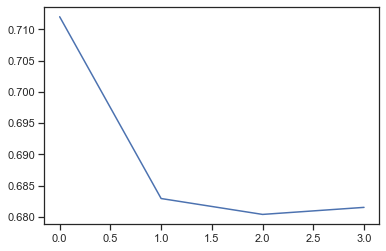

In [276]:
# Plotting the training and validation loss
epochs = range(len(train_list))

plt.plot(epochs, train_list, label='Train Loss')
plt.plot(epochs, valid_list, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


epochs = range(len(train_list))

plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, valid_acc_list, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [13]:
# Specify the file path to save the model
file_path = 'M06_GNN-DDD-10000-k-40-100.pt'

# Save the model
torch.save(model.state_dict(), file_path)

In [18]:
model.load_state_dict(torch.load('M06_GNN-DDD-10000-k-40-100.pt'))

<All keys matched successfully>

In [277]:
#test_dl = DataLoader(data_list[:500], batch_size = 1)
n_param = len(df_param)
pred_list, true_list = [[0,0,0,0] for n in range(n_param)], [[] for n in range(n_param)]
acc_sum = [0 ,0 ,0 ,0 ,0]
total_sum = [0 ,0 ,0 ,0 ,0]



model.eval()
for data in test_dl:
    out = model(data.to(device=device))
    pred_params = torch.argmax(out,dim=1)[0]
    true_params = torch.argmax(data.y,axis=0)

    acc = torch.sum(torch.argmax(data.y,axis=0)==torch.argmax(out,dim=1)[0]).item()


    pred_list[true_params][pred_params]+=1




    if (true_params == 0):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1

    elif (true_params == 1):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1
    
    elif (true_params == 2):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1
    
    elif (true_params == 3):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1

acc_sum[4]    =   sum(acc_sum[:-1])
total_sum[4]  =   sum(total_sum[:-1])





In [279]:
print(acc_sum)
print(total_sum)
print(pred_list)

[190, 351, 0, 0, 541]
[476, 474, 0, 0, 950]
[[190, 286, 0, 0], [123, 351, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]


In [280]:
from collections import Counter
# Initialize a list to store the counts for each sublist
counts_per_sublist = []

# Iterate over each sublist in the main list
for sublist in pred_list:
    # Count the occurrences of numbers 1 to 4 in the sublist
    counts = [sublist.count(i) for i in range(1, 5)]
    # Append the counts to the result list
    counts_per_sublist.append(counts)

# Display the counts
for i, counts in enumerate(counts_per_sublist):
    print(f"Counts for sublist {i+1}: {counts}")

Counts for sublist 1: [0, 0, 0, 0]
Counts for sublist 2: [0, 0, 0, 0]
Counts for sublist 3: [0, 0, 0, 0]
Counts for sublist 4: [0, 0, 0, 0]


In [283]:
result = [a / b if b != 0 else 0 for a, b in zip(acc_sum, total_sum)]

print("Accuracy pred CRBD: %.3f ,Bisse: %.3f ,DDD: %.3f ,PLD: %.3f ,Total: %.3f   " % tuple(result))


Accuracy pred CRBD: 0.399 ,Bisse: 0.741 ,DDD: 0.000 ,PLD: 0.000 ,Total: 0.569   


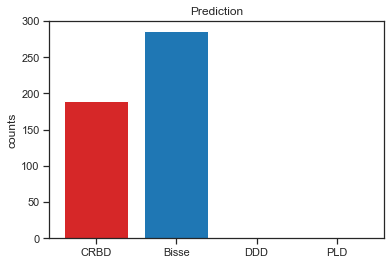

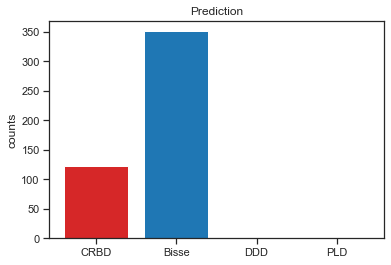

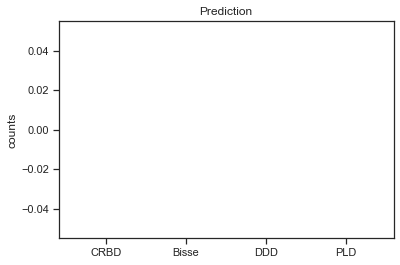

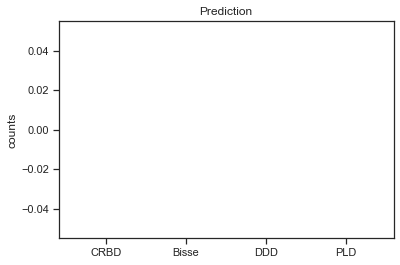

In [285]:
for i, sublist in enumerate(pred_list):
    fig, ax = plt.subplots()

    preds = ['CRBD', 'Bisse', 'DDD', 'PLD']
    counts = sublist
    bar_labels = ['red', 'blue', 'red', 'orange']
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

    ax.bar(preds, counts, color=bar_colors)

    ax.set_ylabel('counts')
    ax.set_title('Prediction')

    plt.show()



In [51]:
saveRDS = robjects.r['saveRDS']
saveRDS(pred_list, "predGNN_DDD_small.rds")

<rpy2.rinterface_lib.sexp.NULLType object at 0x12e5d4980> [RTYPES.NILSXP]

In [25]:
def get_nrmse(true, pred):

    """ Compute the Normalized Root Mean Square Error of 
    Predictions vs. Truth """
    mse = np.square(np.subtract(true, pred)).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse / np.mean(true)
    return nrmse

for m in range(n_param):
        nrmse = get_nrmse(true_list[m], pred_list[m])
        print(f"NRMSE {param[m]}: {nrmse} ")


NRMSE Lambda0: 0.2575107480829784 
NRMSE Mu: 0.2552377322376925 
NRMSE K: 0.14693749732206138 


### Computing NRMSE by tree Size

In [29]:
phyloname= "data/phylogeny-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-40-100-age-15-ddmod-1.rds"
phylo = readRDS(phyloname)
df_phylo = pandas2ri.rpy2py(phylo)

node_values = [phylo[i].rx2('Nnode')[0] for i in test_ind]

# Group the indices based on the Nnode values
grouped_indices = {}
for i, node_value in enumerate(node_values):
    if node_value not in grouped_indices:
        grouped_indices[node_value] = []
    grouped_indices[node_value].append(i)

In [30]:
param = ["Lambda0", "Mu","K"]
h = {}
for i, name in enumerate(param):
    h[name] = {}

    # Iterate over each group
    for node_value, indices in grouped_indices.items():
        nrmse_values = []
        # Get the values for the current name and tree indices
        true_values =  [true_list[i][k] for k in indices]
        pred_values = [pred_list[i][k] for k in indices]
        nrmse = get_nrmse(true_values, pred_values)
        nrmse_values.append(nrmse)

        # Store the values in h
        h[name][node_value] = nrmse_values

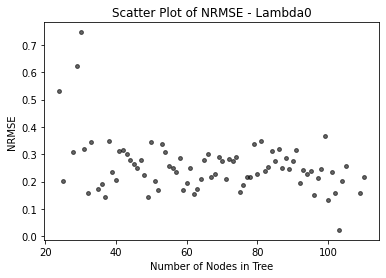

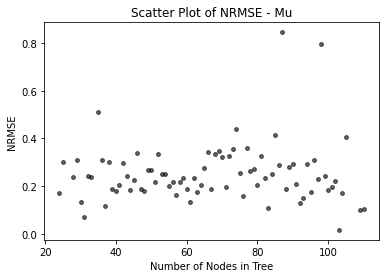

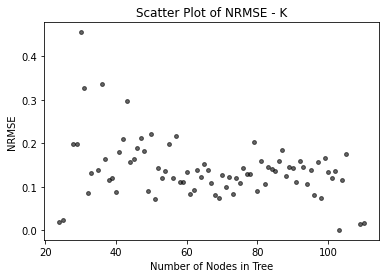

In [32]:
for name, values in h.items():
    # Create a scatter plot
    x = [int(node_value) for node_value in values.keys()]
    y = [value for value in values.values()]
    plt.scatter(x, y,s = 15, c = "black", alpha = .6)
    plt.xlabel('Number of Nodes in Tree')
    plt.ylabel('NRMSE')
    plt.title(f"Scatter Plot of NRMSE - {name}")
    plt.show()